In [1]:
from kw_transformer import TransAm
import math
import pandas as pd
import numpy as np
import time
from datetime import datetime
import copy
import os
import random
from typing import Optional, Any, Union, Callable, Tuple
import mlflow

import torch
from torch import nn
from torch import Tensor
import torch.optim as optim
import torch.nn.functional as F

#from kw_lstm import LSTMModel
from kw_transformer import TransAm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from kw_transformer_functions import calculate_metrics, RMSELoss, RMSPELoss, plot_dataset, inverse_transform, format_predictions, train_val_test_split , plot_predictions, kw_dataload,final_split,final_dataload
from models.transformer.my_functrions import make_dataset, get_torch_data_loaders


In [2]:
df = pd.read_csv(
    #'../datasets/prepared/ta_corr_with_logg_diffed.csv',
    '../datasets/prepared/btc/ta_corr_01_fd.csv',
    parse_dates=True
)
target_col = 'log_returns'
df = df.set_index(['timestamp'])
df.index = pd.to_datetime(df.index)
exclude_cols = ['log_close', 'Close']
df

,log_close,Close,log_returns,diff_fear_greed,volatility_kcp,volume_em,volume_vpt,momentum_stoch_rsi,volatility_bbp,momentum_stoch,...,trend_macd_diff,trend_stc,volume_sma_em,trend_aroon_ind,momentum_tsi,trend_aroon_down,trend_vortex_ind_neg,trend_psar_down_indicator,trend_adx_neg,volatility_bbli
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-11-27,5.912611,369.670013,0.003523,-0.006765,0.501327,-40.468161,-3.149466e+05,0.388997,0.425509,34.013853,...,-0.855557,24.373770,-502.853674,36.0,-0.527280,4.0,1.288202,0.0,20.285280,0.0
2014-11-28,5.930777,376.446991,0.018166,0.007878,0.726950,-52.121651,4.515396e+05,0.748693,0.490535,48.927911,...,-0.354460,46.507056,-281.225092,32.0,0.152113,4.0,1.133492,0.0,22.078843,0.0
2014-11-29,5.928234,375.490997,-0.002543,-0.012831,0.700354,927.476194,3.816202e+05,0.714180,0.469128,47.481343,...,-0.099079,68.204734,0.631289,28.0,0.610003,4.0,1.070125,0.0,20.806231,0.0
2014-11-30,5.935019,378.046997,0.006784,-0.003504,0.764513,-196.001510,2.354075e+04,0.813134,0.496233,51.348971,...,0.213258,84.102367,40.733570,20.0,1.277897,8.0,1.032653,0.0,20.063468,0.0
2014-12-01,5.938182,379.244995,0.003164,-0.007124,0.718714,133.611388,9.986327e+04,1.000000,0.504775,69.447910,...,0.457770,92.051184,-12.443357,20.0,1.977937,4.0,1.119928,0.0,19.494893,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-29,10.230843,27745.884766,-0.012171,0.987829,1.050246,2858.497078,4.753301e+08,0.811280,0.932253,73.001414,...,142.801589,75.000019,451.343496,-76.0,-8.043034,80.0,0.918640,0.0,18.152938,0.0
2023-05-30,10.229273,27702.349609,-0.001570,-0.001570,0.955887,-624.340933,-2.044453e+08,0.787049,0.897492,71.288406,...,158.821013,87.500010,434.361789,-72.0,-5.906286,76.0,0.923086,0.0,17.383497,0.0
2023-05-31,10.211695,27219.658203,-0.017578,-1.017578,0.580642,-2882.568661,-2.935917e+08,0.526399,0.601630,52.295615,...,132.467667,93.750005,251.374776,-68.0,-5.567434,72.0,0.962587,0.0,22.440350,0.0


<Axes: xlabel='timestamp'>

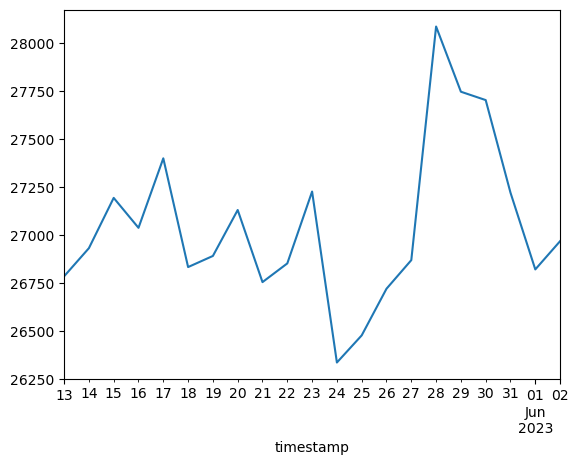

In [83]:
df.tail(21)['Close'].plot()

In [73]:

#checkpoint_path = 'checkpoints/multioutput/best_checkpoints/fac_dense_timestep=10epoch=36-val_loss=0.565.ckpt' #best yet
# checkpoint_path = 'checkpoints/multioutput/ta_corr_01_fd4/tune_transformer/train_transformer_559f8bf8_50_attn_type=fac_dense,batch_size=4,dropout=0.1000,horizon=14,learning_rate=0.0000,model_checkpoint_out_2023-06-03_01-48-19/checkpoints/multioutput/ta_corr_01_fd4/fac_dense_timestep=5epoch=44-val_loss=0.569.ckpt'
#checkpoint_path = 'checkpoints/multioutput/best_checkpoints/fac_dense_timestep=14epoch=49-val_loss=0.739.ckpt'
#checkpoint_path = 'checkpoints/multioutput/best_checkpoints/fac_dense_timestep=40epoch=10-val_loss=0.758.ckpt'
#checkpoint_path = 'checkpoints/multioutput/best_checkpoints/fac_dense_timestep=50epoch=14-val_loss=0.756.ckpt'
#checkpoint_path = 'checkpoints/multioutput/best_checkpoints/fac_dense_timestep=5epoch=44-val_loss=0.569.ckpt' #SUUUUUUUUUUUUUUUUPPPPPPPPPEEEEEEEEERRRRRRRRRRR
#checkpoint_path = 'checkpoints/multioutput/additional_training/btc_eth_fac_dense_timestep=5epoch=7-val_loss=0.574.ckpt' #above + trained on eth, good results

checkpoint_path = 'checkpoints/multioutput/best_checkpoints/fac_dense_timestep=26epoch=31-val_loss=0.882.ckpt' # STATE OF THE ART!!!!!!!!!!!
#checkpoint_path = 'checkpoints/multioutput/best_checkpoints/fac_dense_timestep=26epoch=99-val_loss=0.827.ckpt'
#checkpoint_path = 'checkpoints/multioutput/best_checkpoints/fac_dense_timestep=26epoch=6-val_loss=0.750.ckpt'

checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
print(checkpoint["hyper_parameters"])

#loss_fn=checkpoint["hyper_parameters"]['loss_fn']
batch_size = checkpoint["hyper_parameters"]['batch_size']
#num_layers= checkpoint["hyper_parameters"]['num_layers']
dropout =  checkpoint["hyper_parameters"]['dropout']
#nhead= checkpoint["hyper_parameters"]['nhead']
#feature_size= checkpoint["hyper_parameters"]['feature_size']
learning_rate= checkpoint["hyper_parameters"]['learning_rate']
weight_decay=checkpoint["hyper_parameters"]['weight_decay']

timestep=checkpoint["hyper_parameters"]['timestep']
ntest=21
horizon=checkpoint["hyper_parameters"]['horizon']

{'batch_size': 2, 'feature_size': 36, 'decoder_size': 16, 'timestep': 26, 'horizon': 14, 'num_layers': 4, 'dropout': 0.2, 'nhead': 2, 'attn_type': 'fac_dense', 'learning_rate': 1e-05, 'weight_decay': 1e-06}


In [74]:

Xtrain, Ytrain, Xtest, Ytest, XVal, YVal, scaler = make_dataset(df, target_col='log_returns',
                                                        exclude_cols=exclude_cols, timestep=timestep, ntest=ntest, horizon=horizon)
train_loader, val_loader, test_loader, test_loader_one = get_torch_data_loaders(
    Xtrain, Ytrain, Xtest, Ytest, XVal, YVal, batch_size
)
################################################################
#TODO TRY TO MAKE ETH ASS VALIDATION DATA
################################################################


X.shape (3071, 26, 36) Y.shape (3071, 14)


In [75]:
model = TransAm.load_from_checkpoint(checkpoint_path, map_location=torch.device('cpu'), loss_fn=RMSELoss)
trainer=pl.Trainer(accelerator='cpu')


C:\Users\Olexandr\miniconda3\envs\diploma\lib\site-packages\pytorch_lightning\utilities\migration\utils.py:49: PossibleUserWarning:

The loaded checkpoint was produced with Lightning v2.0.2, which is newer than your current Lightning version: v1.9.3

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


kw_batch,feature size:  2 36
embed_dim: 36
num_heads:  2


In [76]:
trainer.test(model, test_loader_one)

C:\Users\Olexandr\miniconda3\envs\diploma\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test loss           0.4069960415363312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'Test loss': 0.4069960415363312}]

In [77]:
preds = trainer.predict(model, test_loader_one) # predicted result


C:\Users\Olexandr\miniconda3\envs\diploma\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

In [78]:
def test_prediction_onestep(preds, real):
    predictions = np.concatenate(preds, axis=0).ravel()
    values = []
    for x_test, y_test in test_loader_one:
        #values.append(y_test.to(device).detach().cpu().numpy())
        values.append(y_test.cpu().numpy())
    vals = np.concatenate(values, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": predictions})
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    df_result.plot()

def test_predictions_multistep(
    preds, real, scaler, unscale=False, last_train=None,
    apply_func_to_preds=None, concat=False, step=1
):
    if concat:
        predictions = np.concatenate(preds)
    else:
        predictions = preds
    # if unscale:
    #     predictions = scaler.inverse_transform(predictions)
    #     real = scaler.inverse_transform(real)
    for i in range(0, predictions.shape[0] - 1, step):
        if unscale:
            unscaled_y_test = scaler.inverse_transform(real[i].reshape(-1, 1)).flatten()
            real_prices = [np.exp(last_train), *np.exp(last_train +  np.cumsum(unscaled_y_test))]


            prediction = apply_func_to_preds(predictions[i]) if apply_func_to_preds else predictions[i]
            unscaled_prediction = scaler.inverse_transform(prediction.reshape(-1, 1)).flatten()
            #tmp = np.exp(last_train +  np.cumsum(unscaled_prediction))
            #print(prediction)
            kek = [np.exp(last_train), *np.exp(last_train +  np.cumsum(unscaled_prediction))]

            df = pd.DataFrame(data={"real price": real_prices, "prediction": kek})
        else:
            df = pd.DataFrame(data={"real price": real[i], "prediction": predictions[i]})
        #pd.DataFrame(data={"value": real[i], "prediction": predictions[i] * 10}).plot()
        df.plot(title=f'Experiment {i}')



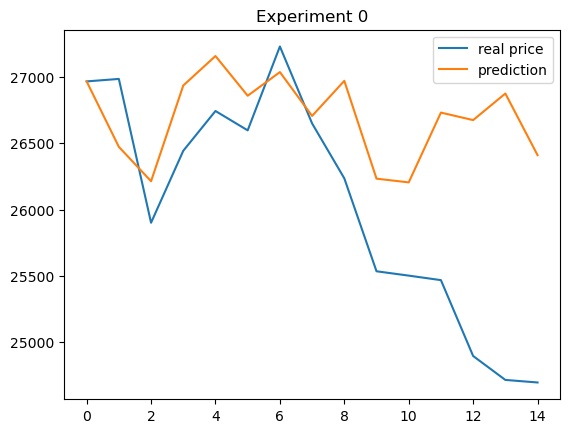

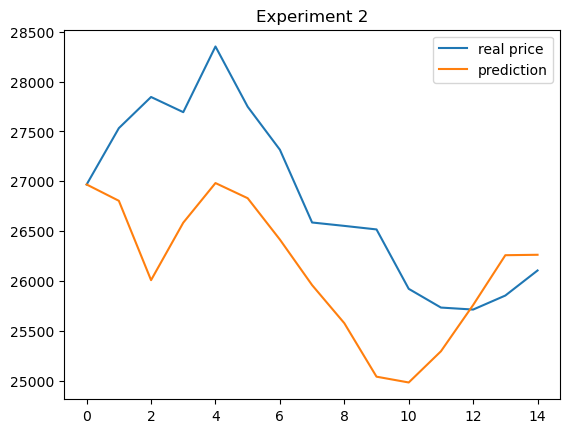

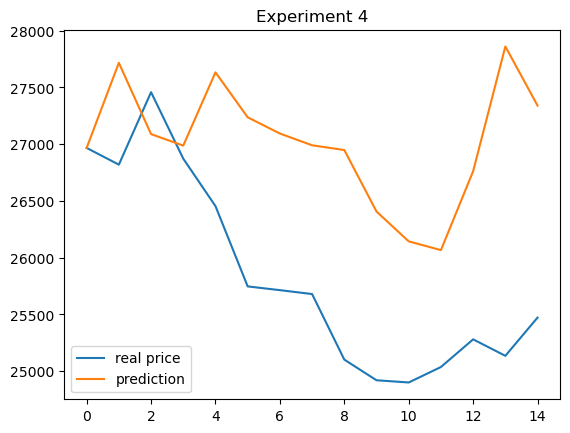

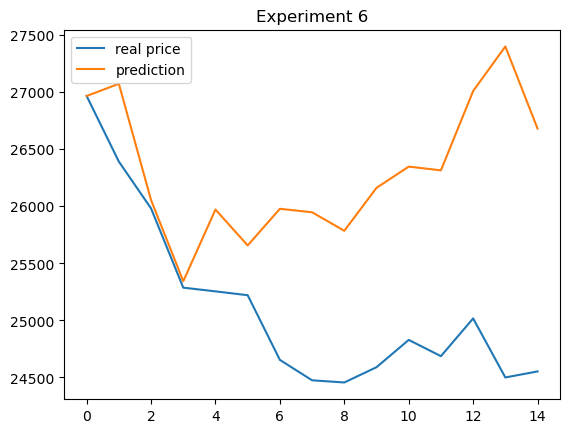

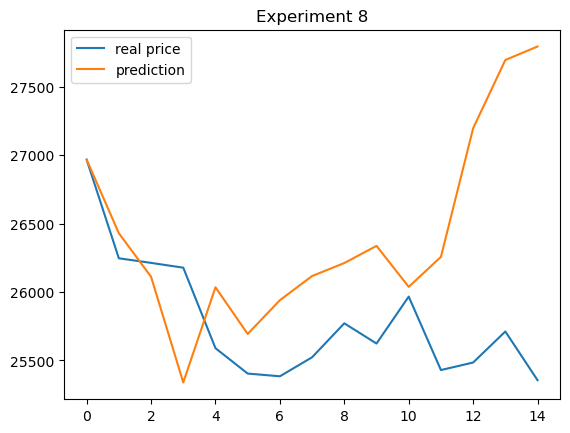

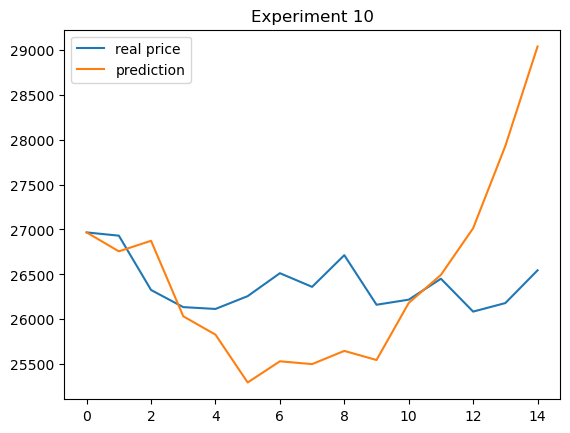

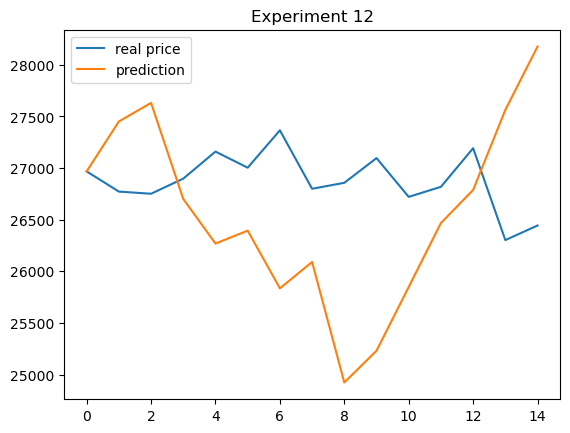

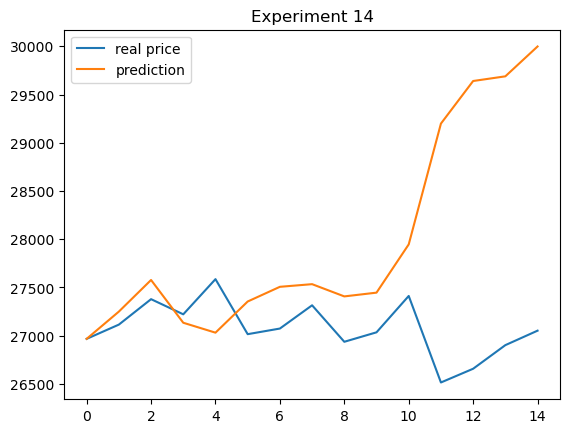

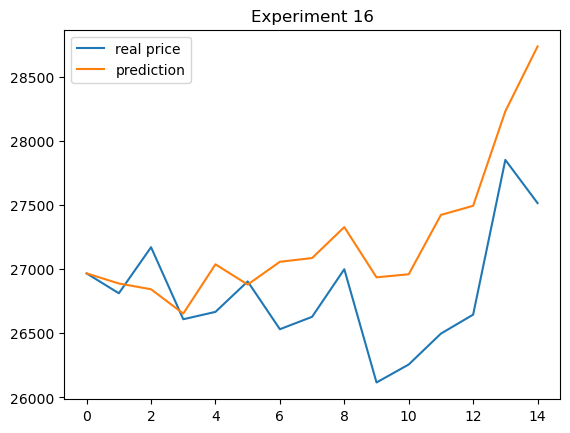

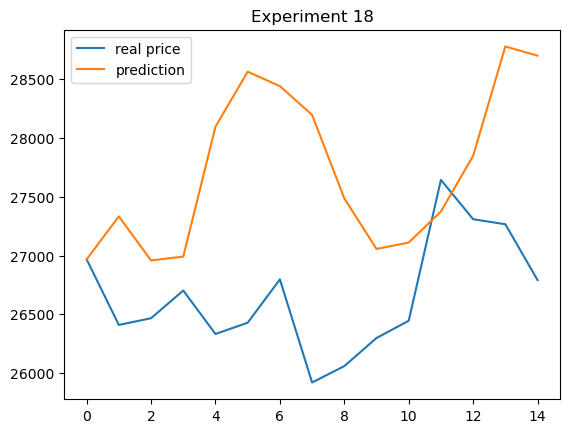

In [84]:
train = df.iloc[:-ntest]
last_train = df.iloc[-1]['log_close']

#apply_func_to_preds = lambda x: x + x.mean()
apply_func_to_preds = lambda x: x * 10
#apply_func_to_preds = None


test_predictions_multistep(
    preds, Ytest, scaler,  unscale=True, last_train=last_train, apply_func_to_preds=apply_func_to_preds, concat=True,
    step=2
)

In [39]:
model2 = TransAm.load_from_checkpoint('checkpoints/multioutput/btc_eth/fac_dense_timestep=5epoch=7-val_loss=0.574.ckpt', map_location=torch.device('cpu'), loss_fn=RMSELoss)

kw_batch,feature size:  4 36
embed_dim: 36
num_heads:  4


In [40]:
preds2 = trainer.predict(model2, test_loader_one)

C:\Users\Olexandr\miniconda3\envs\diploma\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

C:\Users\Olexandr\miniconda3\envs\diploma\lib\site-packages\pandas\plotting\_matplotlib\core.py:512: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



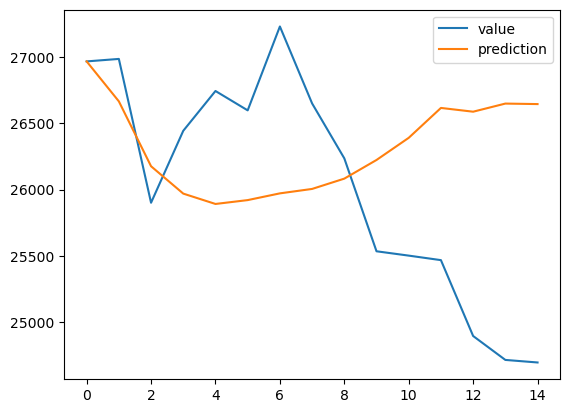

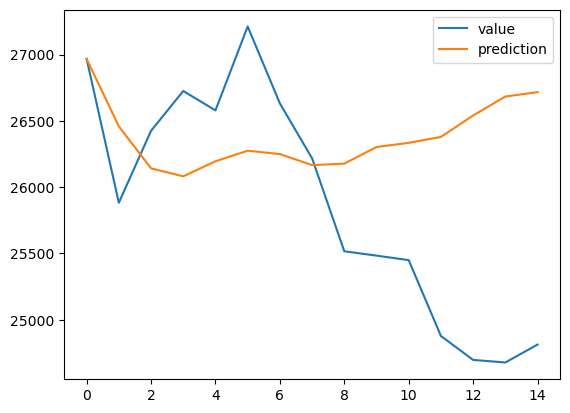

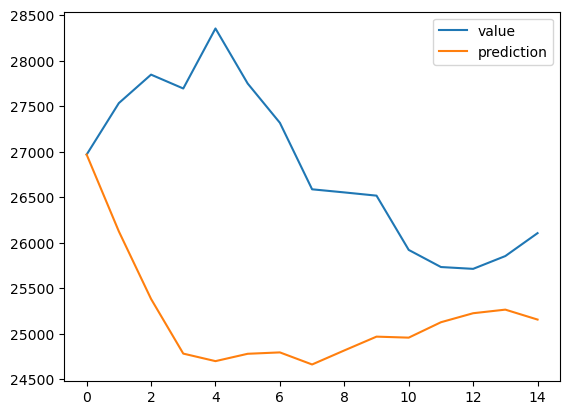

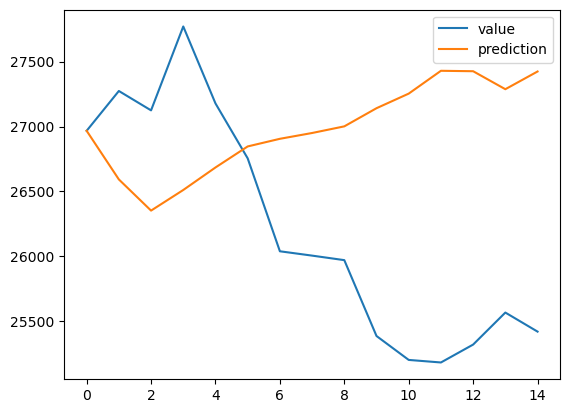

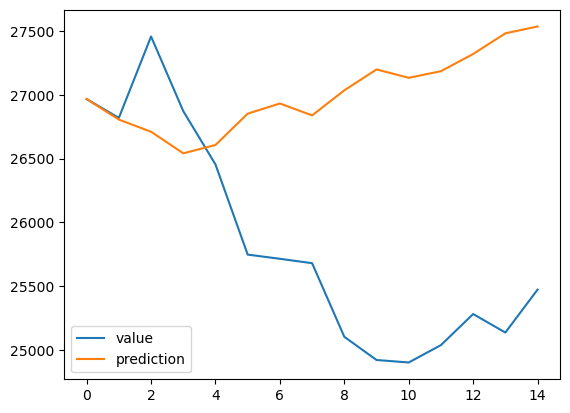

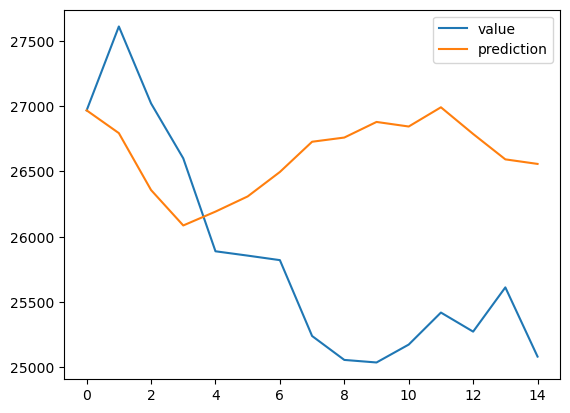

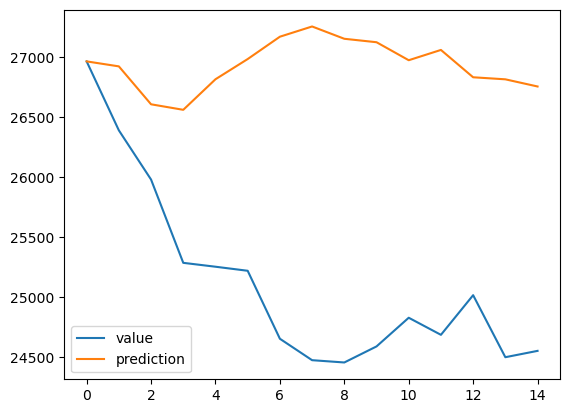

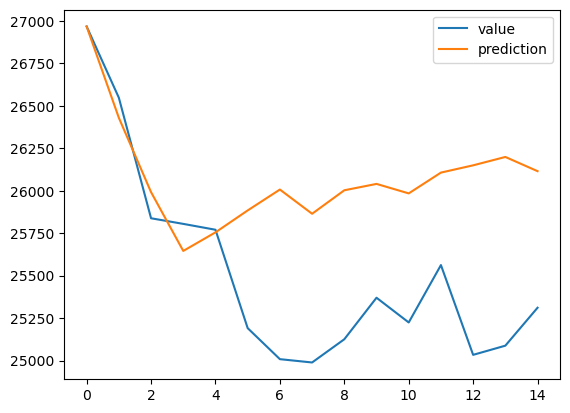

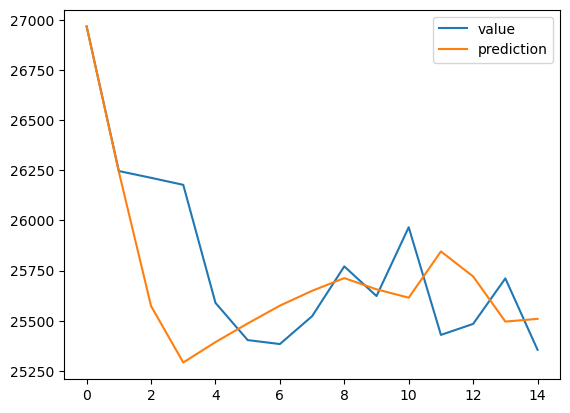

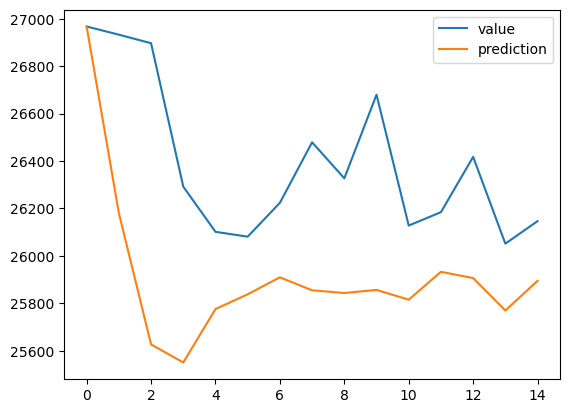

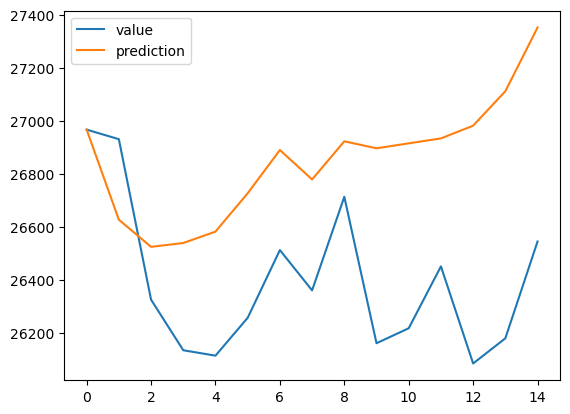

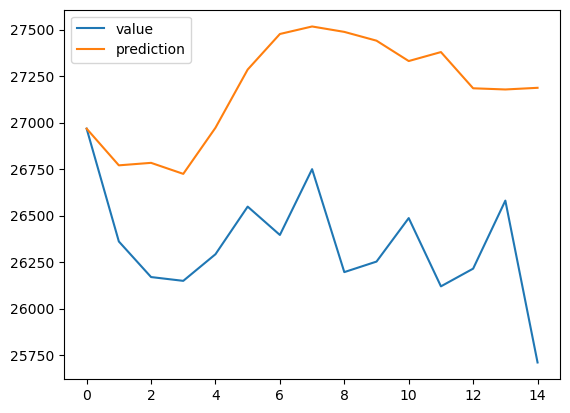

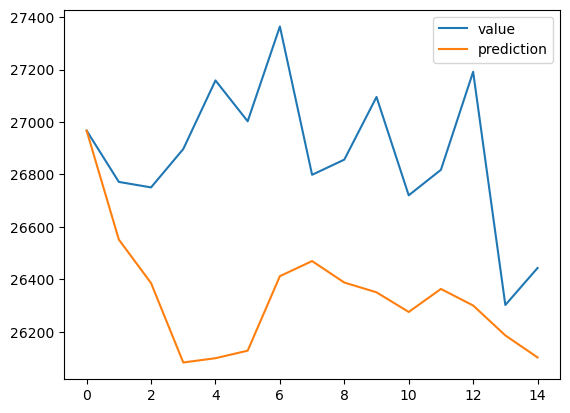

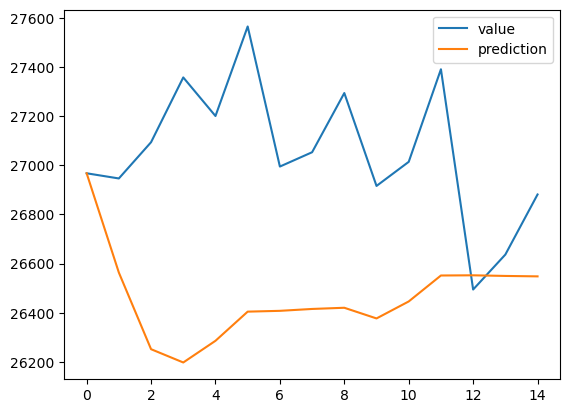

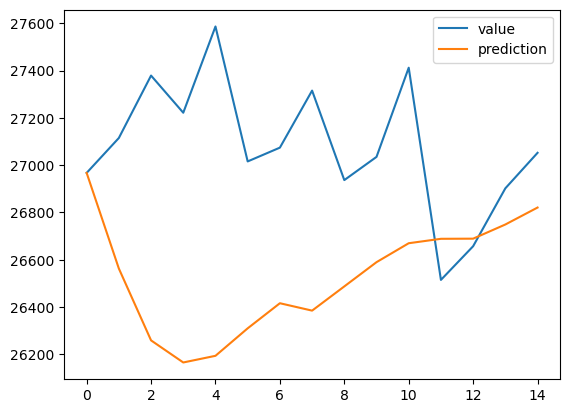

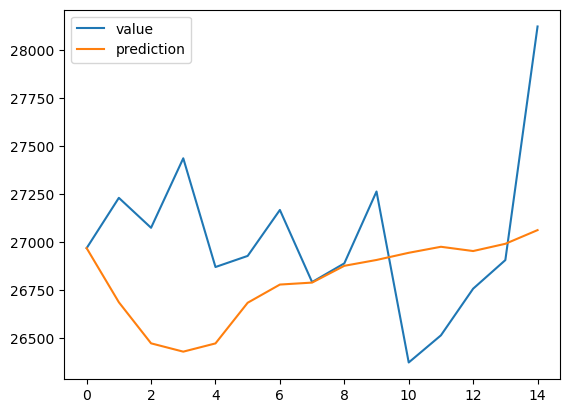

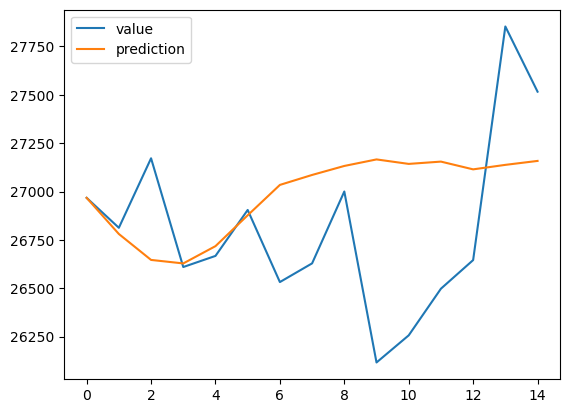

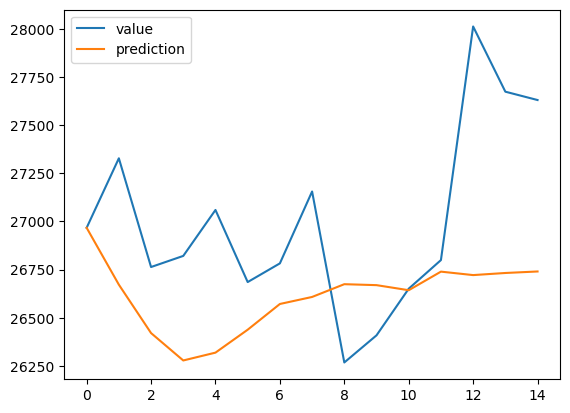

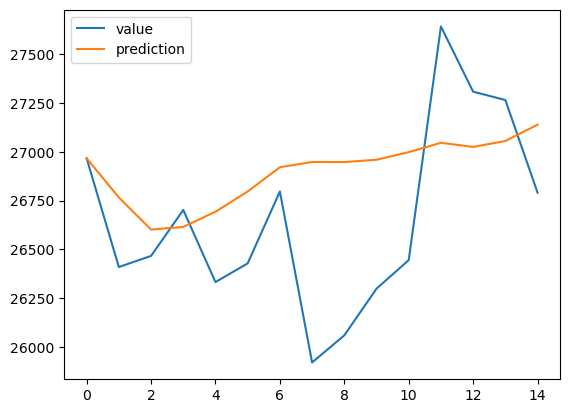

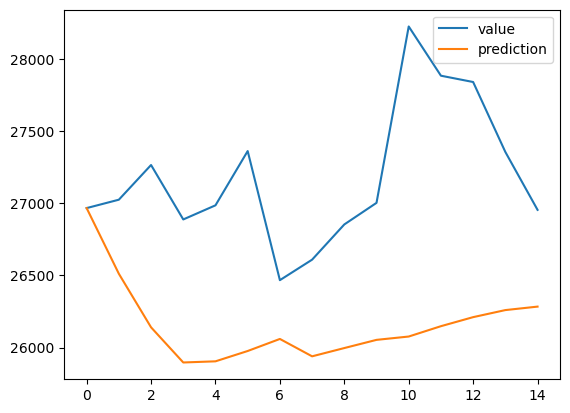

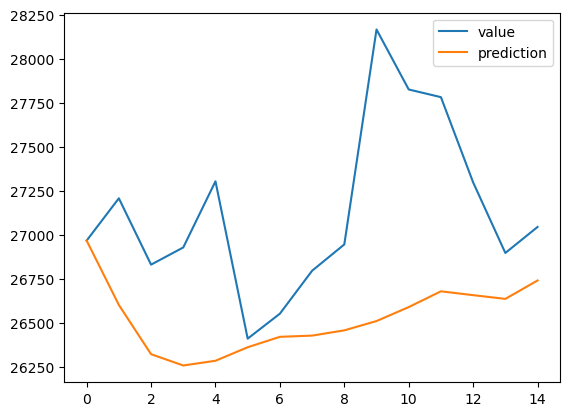

In [41]:
test_predictions_multistep(preds2, Ytest, scaler, unscale=True, last_train=last_train, apply_func_to_preds=None)

In [59]:
model3 = TransAm.load_from_checkpoint('checkpoints/multioutput/additional_training/btc_eth_ada_fac_dense_timestep=26epoch=13-val_loss=0.622.ckpt', map_location=torch.device('cpu'), loss_fn=RMSELoss)
preds3 = trainer.predict(model3, test_loader_one)

kw_batch,feature size:  2 36
embed_dim: 36
num_heads:  2


C:\Users\Olexandr\miniconda3\envs\diploma\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x180 and 936x14)